In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error


### preprocessing the Data and Scaling

In [39]:

# Load the dataset
file_path = 'bitcoin.csv'  # replace with actual path
bitcoin_data = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'], format='%m/%d/%Y')
bitcoin_data.set_index('Date', inplace=True)

# Calculate technical indicators (SMA, EMA, RSI)
# Simple Moving Average (SMA)
bitcoin_data['SMA'] = bitcoin_data['Price'].rolling(window=14).mean()

# Exponential Moving Average (EMA)
bitcoin_data['EMA'] = bitcoin_data['Price'].ewm(span=14, adjust=False).mean()

# Relative Strength Index (RSI)
delta = bitcoin_data['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
bitcoin_data['RSI'] = 100 - (100 / (1 + rs))

# Drop any NaN values created by rolling calculations
bitcoin_data = bitcoin_data.dropna()

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data[['Price', 'SMA', 'EMA', 'RSI']])

# Prepare the dataset for LSTM
look_back = 60  # Look back for 60 days

def create_dataset(data, look_back=look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, 0])  # Predict the 'Price' column
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)

# Reshape X to be compatible with LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split the dataset into training and testing sets (80% for training, 20% for testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


### Building and Training LSTMXGRU Model

In [40]:
# Reduce learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Build the model with LSTM and GRU layers
model = Sequential()

# LSTM Layer
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout to avoid overfitting

# GRU Layer
model.add(GRU(units=100, return_sequences=False))
model.add(Dropout(0.2))  # Dropout for regularization

# Dense Layer for output
model.add(Dense(units=1))

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with validation data and learning rate scheduler
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[lr_scheduler])


Epoch 1/30


d:\Josh\Career_Development\Projects\Bitcoin-Prediction\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0791 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0182 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0118 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0091 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0088 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0075 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0083 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0068 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0075 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/ste

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Mean Squared Error: 167251.35590396583
Mean Absolute Error: 327.6156354886062
Root Mean Squared Error: 408.9637586681317


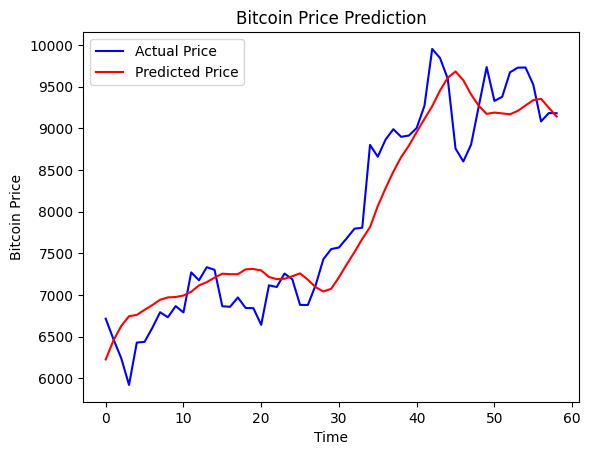

In [43]:
# Predicting on the test set
predicted_price = model.predict(X_test)

# Since the scaler was applied to multiple features, inverse transform only the 'Price' column
# Reshape predicted_price to match the scaler's inverse_transform format (it should be 2D)
predicted_price = scaler.inverse_transform(np.column_stack((predicted_price, np.zeros((predicted_price.shape[0], 3)))))[:, 0]

# Inverse scaling of actual prices (only the 'Price' column)
actual_price = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3)))))[:, 0]

# Calculate MSE, MAE, and RMSE
mse = mean_squared_error(actual_price, predicted_price)
mae = mean_absolute_error(actual_price, predicted_price)
rmse = np.sqrt(mse)

# Print the error metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Plotting the actual vs predicted prices
plt.plot(actual_price, color='blue', label='Actual Price')
plt.plot(predicted_price, color='red', label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


#### Next Day Price Prediction

In [45]:
# Get the last 60 days of data for prediction
last_60_days = scaled_data[-60:]
last_60_days = last_60_days.reshape(1, 60, 4)

# Predict the next day's price
next_day_price = model.predict(last_60_days)
next_day_price = scaler.inverse_transform(np.column_stack((next_day_price, np.zeros((next_day_price.shape[0], 3)))))[:, 0]
print(f'The predicted price for the next day is: {next_day_price[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The predicted price for the next day is: 9072.133698617847
